# Ray Train: scaling to multiple devices

In [2]:
from ray_demo.utils.constants import ROOT_DIR

from dotenv import load_dotenv

load_dotenv(ROOT_DIR / ".env")

True

In [ ]:
# import os

# os.environ["AWS_PROFILE"] = "<your AWS profile>" # Update accordingly
# os.environ["RAY_ADDRESS"] = "http://<head-node-public-ip:8265/" # Update accordingly

## Load and split the data

In [3]:
# Option 1 (S3): a "realistic" scenario where really big datasets would be stored in the cloud.
import boto3

s3 = boto3.client("s3")
bucket = "ray-demo-data"

image_filenames = []
mask_filenames = []

paginator = s3.get_paginator("list_objects_v2")

for result in paginator.paginate(Bucket=bucket, Prefix="football-players-recognizer/images/"):
    for content in result.get("Contents", []):
        image_filenames.append(content["Key"])

for result in paginator.paginate(Bucket=bucket, Prefix="football-players-recognizer/masks/"):
    for content in result.get("Contents", []):
        mask_filenames.append(content["Key"])


# Option 2 (local directory): you know, a safeguard for the demo...
# import os

# image_to_mask_map = dict()

# for img_file in os.listdir(IMAGES_DIR):
#     image_to_mask_map[img_file] = img_file.replace("image", "mask")


In [4]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(image_filenames, mask_filenames, test_size=0.1, random_state=180)
images_train, images_val, masks_train, masks_val = train_test_split(images_train, masks_train, test_size=0.1127, random_state=180) # 0.1 * 0.9 = 0.1127

In [5]:
len(images_train), len(images_val), len(images_test)

(408, 52, 52)

In [6]:
import torch

from torchvision.transforms import v2

image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

mask_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
])

In [7]:
from ray_demo.datasets import SegmentationS3Dataset

train_dataset = SegmentationS3Dataset(
    bucket=bucket,
    image_files=images_train,
    mask_files=masks_train,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = SegmentationS3Dataset(
    bucket=bucket,
    image_files=images_val,
    mask_files=masks_val,
    transform=image_transform,
    target_transform=mask_transform
)

test_dataset = SegmentationS3Dataset(
    bucket=bucket,
    image_files=images_test,
    mask_files=masks_test,
    transform=image_transform,
    target_transform=mask_transform
)

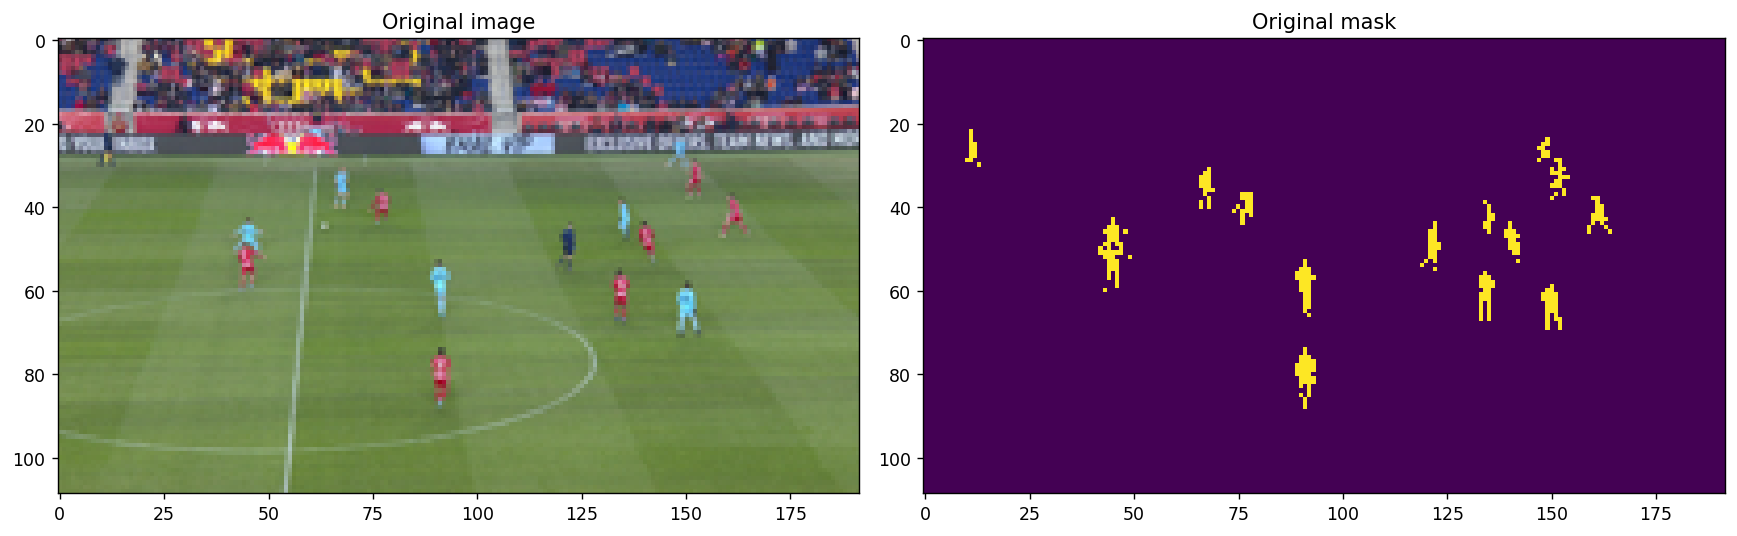

In [8]:
import numpy as np
import matplotlib.pyplot as plt

X = test_dataset[int(np.random.random()*len(test_dataset))]

image = X[0].unsqueeze(0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=125)

axs[0].set_title("Original image")
axs[0].imshow(X[0].permute(1, 2, 0))

axs[1].set_title("Original mask")
axs[1].imshow(X[1].permute(1, 2, 0))

plt.tight_layout()

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [10]:
import lightning as L

from torch import nn
from torchmetrics.classification import BinaryJaccardIndex, Dice

from ray_demo.models.unet import UNet


class LitSegmenter(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(n_channels=3, n_classes=1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.dice = Dice()
        self.iou = BinaryJaccardIndex()
        self.example_input_array = torch.rand(BATCH_SIZE, 3, 216, 384)

        self.validation_step_outputs = {
            "val_loss": [],
            "val_dice": [],
            "val_iou": [],
        }

        self.testing_step_outputs = {
            "test_loss": [],
            "test_dice": [],
            "test_iou": [],
        }

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, masks = batch
        
        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)

        self.log("train_loss", loss)

        return loss

    def clear_validation_outputs(self):
        self.validation_step_outputs = {
            "val_loss": [],
            "val_dice": [],
            "val_iou": [],
        }
    
    def clear_testing_outputs(self):
        self.testing_step_outputs = {
            "test_loss": [],
            "test_dice": [],
            "test_iou": [],
        }

    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, masks = batch

        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)
        dice = self.dice(outputs, masks.int())
        iou = self.iou(outputs, masks.int())

        self.validation_step_outputs["val_loss"].append(loss)
        self.validation_step_outputs["val_dice"].append(dice)
        self.validation_step_outputs["val_iou"].append(iou)

        return loss

    def on_validation_epoch_end(self):
        """
        Computes average validation loss
        """
        avg_loss = torch.stack(self.validation_step_outputs["val_loss"]).mean()
        avg_dice = torch.stack(self.validation_step_outputs["val_dice"]).mean()
        avg_iou = torch.stack(self.validation_step_outputs["val_iou"]).mean()
        self.log_dict({"val_loss": avg_loss, "val_dice": avg_dice, "val_iou": avg_iou})

        self.clear_validation_outputs()

    def test_step(self, batch, batch_idx):
        images, masks = batch

        outputs = self.model(images)

        loss = self.loss_fn(outputs, masks)
        dice = self.dice(outputs, masks.int())
        iou = self.iou(outputs, masks.int())
        
        self.testing_step_outputs["test_loss"].append(loss)
        self.testing_step_outputs["test_dice"].append(dice)
        self.testing_step_outputs["test_iou"].append(iou)

        return loss

    def on_test_epoch_end(self):
        avg_test_loss = torch.stack(self.testing_step_outputs["test_loss"]).mean()
        avg_test_dice = torch.stack(self.testing_step_outputs["test_dice"]).mean()
        avg_test_iou = torch.stack(self.testing_step_outputs["test_iou"]).mean()

        self.log_dict({"test_loss": avg_test_loss, "test_dice": avg_test_dice, "test_iou": avg_test_iou}, prog_bar=True)

        self.clear_testing_outputs()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def forward(self, x):
        return self.model(x)


segmenter = LitSegmenter()

In [11]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
 

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=3,
    every_n_epochs=5,
    mode="min",
    # save_weights_only=True
)

early_stopping = EarlyStopping(monitor="val_loss", mode="min")

wandb_logger = WandbLogger(
    project="Football Players Segmentation",
    log_model="all",
)

wandb_logger.watch(segmenter, log_freq=10)
wandb_logger.experiment.config["batch_size"] = BATCH_SIZE

trainer = L.Trainer(
    max_epochs=30,
    check_val_every_n_epoch=2,
    accelerator="mps",
    devices=1,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ],
    logger=wandb_logger
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: facupalavecino (facupalavecino-mutt-data). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model=segmenter, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name    | Type               | Params | In sizes         | Out sizes       
-------------------------------------------------------------------------------------
0 | model   | UNet               | 17.3 M | [8, 3, 216, 384] | [8, 1, 216, 384]
1 | loss_fn | BCEWithLogitsLoss  | 0      | ?                | ?               
2 | dice    | Dice               | 0      | ?                | ?               
3 | iou     | BinaryJaccardIndex | 0      | ?                | ?               
-------------------------------------------------------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.070    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [13]:
trainer.test(model=segmenter, dataloaders=test_loader, ckpt_path="best")

Restoring states from the checkpoint path at ./Football Players Segmentation/qvkbe88c/checkpoints/epoch=29-step=1530.ckpt
Loaded model weights from the checkpoint at ./Football Players Segmentation/qvkbe88c/checkpoints/epoch=29-step=1530.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.8126400709152222     │
│         test_iou          │    0.7091928124427795     │
│         test_loss         │    0.1259177178144455     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1259177178144455,
  'test_dice': 0.8126400709152222,
  'test_iou': 0.7091928124427795}]

In [ ]:
import ray.train.lightning
from ray.train.torch import TorchTrainer

In [ ]:
def train_func():
    

config = {"lr": 1e-4, "num_epochs": 10}

## Inference

In [ ]:
raise Exception 

In [ ]:
checkpoint_callback.best_model_path

In [ ]:
checkpoint_callback.best_k_models

In [ ]:
best_model = LitSegmenter.load_from_checkpoint(checkpoint_callback.best_model_path, map_location=torch.device("cpu"))

In [ ]:
path_to_first_model = "./Football Players Segmentation/d6ul28w1/checkpoints/epoch=9-step=510.ckpt"

first_model = LitSegmenter.load_from_checkpoint(path_to_first_model, map_location=torch.device("cpu"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = test_dataset[int(np.random.random()*len(test_dataset))]

image = X[0].unsqueeze(0)

with torch.inference_mode():
    y_pred = best_model(image)
    y_pred_first = first_model(image)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 8), dpi=125)

axs[0].set_title("Image")
axs[0].imshow(X[0].permute(1, 2, 0))

axs[1].set_title("Original mask")
axs[1].imshow(X[1].permute(1, 2, 0))

axs[2].set_title("Predicted mask (best model)")   
axs[2].imshow(y_pred.squeeze(0).permute(1, 2, 0))

axs[3].set_title("Predicted mask (first model)")
axs[3].imshow(y_pred_first.squeeze(0).permute(1, 2, 0))

plt.tight_layout()